In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from igraph import *

In [2]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g.neighbors(node,mode="out"))) < p
                new_ones += list(np.extract(success, g.neighbors(node,mode="out")))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

In [3]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(range(g.vcount()))-set(S):

            # Get the spread
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

In [4]:
def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

In [5]:
def random_subgraph(g, p):
    """
    Generate a random subgraph using edge probabilities.
    Input:  graph object, edge activation probability
    Output: random subgraph as an adjacency matrix
    """
    random_graph = g.copy()
    edges_to_delete = [edge.index for edge in random_graph.es if random.random() < p]
    random_graph.delete_edges(edges_to_delete)
    return random_graph

def monte_carlo_influence(g, seed_nodes, p, mc):
    """
    Perform Monte Carlo simulations to estimate influence spread.
    Input:  graph object, seed nodes, edge activation probability, number of simulations
    Output: estimated influence spread
    """
    influence_spread = 0
    for _ in range(mc):
        active_nodes = set(seed_nodes)
        new_nodes = set(seed_nodes.copy())  # Make a copy to avoid modifying the original seed_nodes

        while new_nodes:
            current_node = new_nodes.pop()
            neighbors = set(g.neighbors(current_node)) - active_nodes
            for neighbor in neighbors:
                if neighbor not in active_nodes and random.random() <= p:  # Check if neighbor is not already active
                    new_nodes.add(neighbor)
                    active_nodes.add(neighbor)

        influence_spread += len(active_nodes)

    return influence_spread / mc

def mixed_greedy(g, k, p=0.1, mc=1000):
    """
    Input:  graph object, number of seed nodes, edge activation probability, Monte Carlo simulations
    Output: optimal seed set, resulting spread
    """
    start_time = time.time()
    subgraph = random_subgraph(g, p)

    # Initialize the sorted list with node indices and their estimated influence spread
    marg_gain = [(node, IC(subgraph, [node], p, mc)) for node in range(g.vcount())]
    Q = sorted(marg_gain, key=lambda x: x[1], reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS,timelapse = Q[1:],[g.vcount()], [time.time() - start_time]

    affected_nodes = set(g.neighbors(S[0]))  # Initialize affected_nodes with neighbors of the first node

    for _ in range(k - 1):
        check, node_lookup = False, 0

        while not check:
            # Count the number of times the spread is computed
            node_lookup += 1
            # Recalculate spread of top node
            current = Q[0][0]

            # Recalculate influence spread and store the marginal gain in the list
            Q[0] = (current, IC(subgraph, S + [current], p, mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key=lambda x: x[1], reverse=True)

            # Check if the previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

        # Update affected_nodes with neighbors of the newly added node
        affected_nodes.update(set(g.neighbors(current)) - set(S))

    return S, SPREAD, timelapse


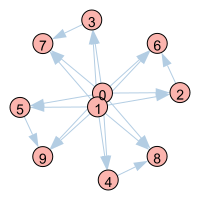

In [6]:
# Create simple network with 0 and 1 as the influential nodes
source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]

g = Graph(directed=True)
g.add_vertices(range(10))
g.add_edges(zip(source,target))

# Plot graph
g.vs["label"], g.es["color"], g.vs["color"] = range(10), "#B3CDE3", "#FBB4AE"
plot(g,bbox = (200,200),margin = 20,layout = g.layout("kk"))

In [7]:
# Run algorithms
celf_output   = celf(g,2,p = 0.2,mc = 1000)
greedy_output = greedy(g,2,p = 0.2,mc = 1000)
mgc_output = mixed_greedy(g, 2, p=0.2, mc=1000)
# Print results
print("celf output:   " + str(celf_output[0]))
print("greedy output: " + str(greedy_output[0]))
desired_order = [0, 1]
seed_nodes = mgc_output[0]
mixed_greedy_output = sorted(seed_nodes, key=lambda x: desired_order.index(x))
print("mixed greedy output:", mixed_greedy_output)

celf output:   [0, 1]
greedy output: [0, 1]
mixed greedy output: [0, 1]


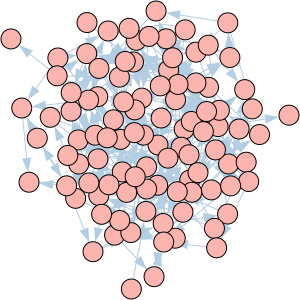

In [12]:
# Generate Graph
G = Graph.Erdos_Renyi(n=100,m=300,directed=True)

# Plot Graph
G.es["color"], G.vs["color"], G.vs["label"] = "#B3CDE3", "#FBB4AE", ""
plot(G, bbox = (300, 300),margin = 11,layout = G.layout("kk"))

In [13]:
# Run algorithms
celf_output   = celf(G,10,p = 0.1,mc = 1000)
mgc_output    = mixed_greedy(G, 10, p=0.1, mc=1000)
greedy_output = greedy(G,10,p = 0.1,mc = 1000)

# Print resulting seed sets
print("celf output:        " + str(celf_output[0]))
print("mixed greedy output:" + str(mgc_output[0]))
print("greedy output:      " + str(greedy_output[0]))

celf output:        [42, 53, 54, 74, 64, 13, 45, 28, 66, 65]
mixed greedy output:[84, 57, 79, 46, 72, 73, 70, 74, 41, 94]
greedy output:      [42, 53, 54, 74, 64, 13, 45, 28, 66, 65]


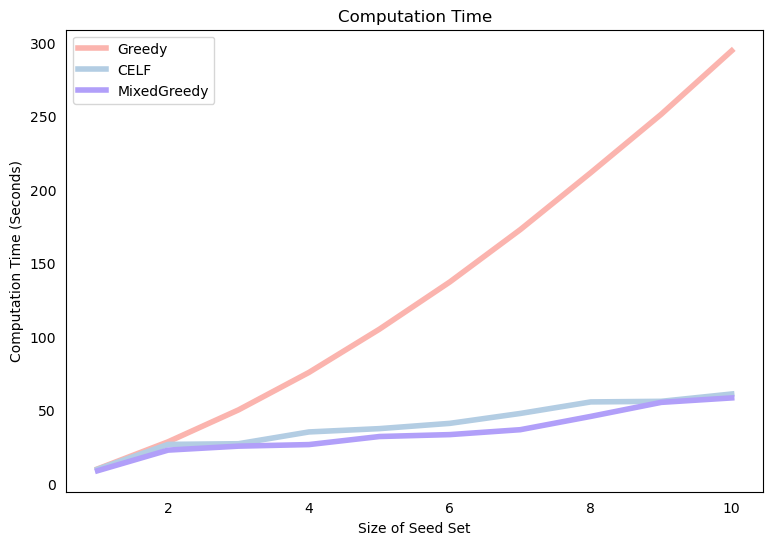

In [14]:
# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# Plot Computation Time
plt.plot(range(1,len(greedy_output[2])+1),greedy_output[2],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[2])+1),celf_output[2],label="CELF",color="#B3CDE3")
plt.plot(range(1,len(celf_output[2])+1),mgc_output[2],label="MixedGreedy",color="#B19FF9")
plt.ylabel('Computation Time (Seconds)'); plt.xlabel('Size of Seed Set')
plt.title('Computation Time'); plt.legend(loc=2);

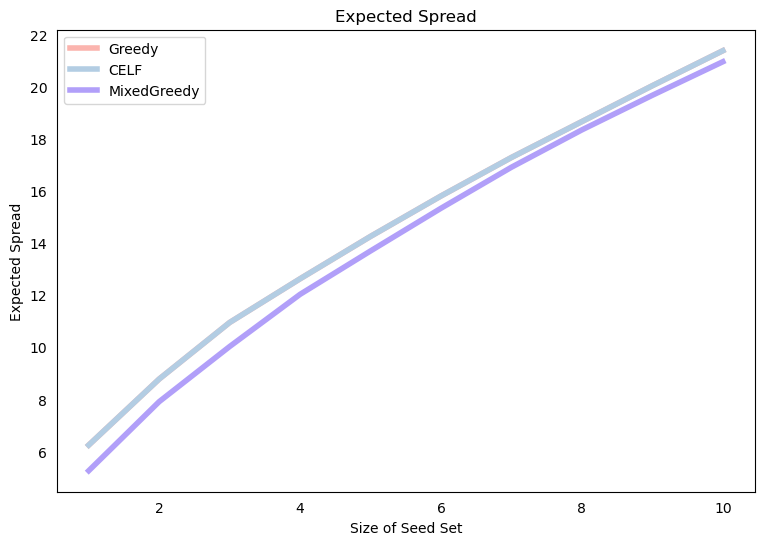

In [15]:
# Plot Expected Spread by Seed Set Size
plt.plot(range(1,len(greedy_output[1])+1),greedy_output[1],label="Greedy",color="#FBB4AE")
plt.plot(range(1,len(celf_output[1])+1),celf_output[1],label="CELF",color="#B3CDE3")
plt.plot(range(1,len(celf_output[1])+1),mgc_output[1],label="MixedGreedy",color="#B19FF9")
plt.xlabel('Size of Seed Set'); plt.ylabel('Expected Spread')
plt.title('Expected Spread'); plt.legend(loc=2);